In [1]:
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy,copy
from myDataset import PalmNutriDataset

# the magic number
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

ground_truth = 'dataset/gt.csv'
full_dataset = PalmNutriDataset(ground_truth=ground_truth, img_dir='dataset', sample_set='k17')
print(len(full_dataset))

900


In [2]:
# train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [800,218])
# train_dataset.dataset = copy(full_train_dataset)
full_dataset.transform = preprocess
# val_dataset.dataset.transform = preprocess

In [3]:
BATCH_SIZE=16
NUM_WORKERS=2
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE,shuffle=True , num_workers=NUM_WORKERS)

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

model = models.alexnet()
model.classifier[6] = torch.nn.Linear(in_features=4096,out_features=1)
model.load_state_dict(torch.load('current_model_k17/alex_sgd_0.01.pth'))
model.eval()
model.to(device)

cuda:1


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
all_preds = None
all_labels = None
with torch.no_grad():
    for index, (inputs,labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.view(-1,1).to(device)
        # print(inputs,labels)
        preds = model(inputs)
        if(all_preds == None):
            all_preds = preds.cpu().view(-1)
            all_labels = labels.cpu().view(-1)
        else:
            all_preds = torch.cat( [all_preds,preds.cpu().view(-1)],dim=0)
            all_labels = torch.cat( [all_labels,labels.cpu().view(-1)],dim=0)
        # print(all_preds.shape, all_labels.shape)
        # plt.scatter((index * 16) + np.arange(16),preds.cpu(),label='prediction')
        # plt.scatter((index * 16) + np.arange(16),labels.cpu(),label='target')
        # if(index == 2):
        #     break

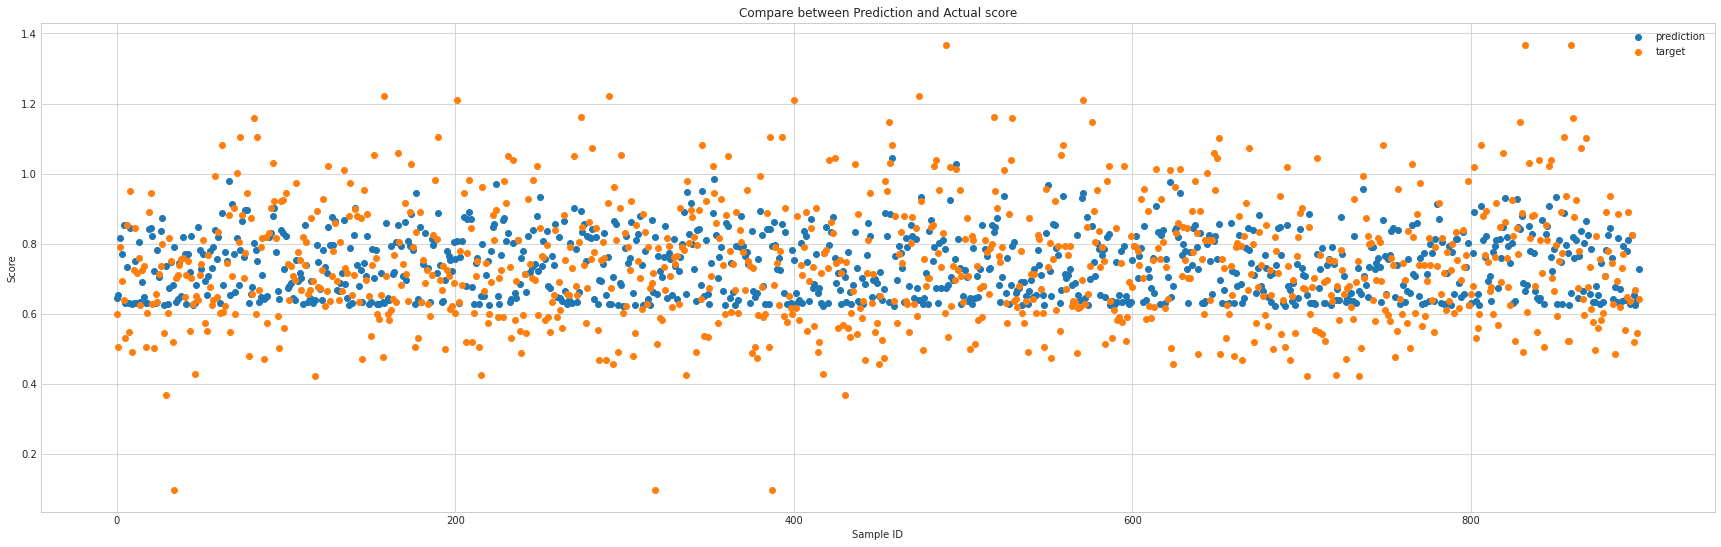

In [7]:
plt.style.use('seaborn-whitegrid')
fig,ax = plt.subplots(figsize=(30,9))
ax.scatter(np.arange(len(all_preds)),all_preds,label='prediction')
ax.scatter(np.arange(len(all_labels)),all_labels,label='target')
ax.set_title('Compare between Prediction and Actual score')
ax.set_ylabel('Score')
ax.set_xlabel('Sample ID')
ax.legend()
plt.show()

In [8]:
import math
def get_class(score):
    k_range = [0,0.75,0.90,1.2,math.inf]
    if(score < .75):
        return 1
    if(score < .9):
        return 2
    if(score < 1.2):
        return 3
    else: return 4


In [9]:
acc = 0
acc_class = dict()
len_class = dict()
err = 0
err_class = dict()
class_3 = []
for idx in range(len(all_preds)):
    pred,label = all_preds[idx], all_labels[idx]
    class_pred = get_class(pred)
    class_act = get_class(label)
    
    if(class_act not in len_class.keys()):
        acc_class[class_act] = 0
        err_class[class_act] = 0
        len_class[class_act] = 1

    if(class_act == class_pred):
        acc += 1
        acc_class[class_act] += 1
    len_class[class_act] += 1
    err += abs(pred - label)
    err_class[class_act] += abs(pred - label)
    if(class_act == 3 and class_pred != 3):
        class_3.append((full_dataset.filenames[idx],pred,label))

print('Over All acc: ',acc/len(all_preds) * 100)
print('Over All err: ',err/len(all_preds))

for k,v in acc_class.items():
    print(f"Acc of Class {k}: {v}/{len_class[k]} = {v/len_class[k] * 100}")
    print(f"Err of Class {k}: {err_class[k]/len_class[k]}")

Over All acc:  61.22222222222222
Over All err:  tensor(0.1056)
Acc of Class 1: 389/508 = 76.5748031496063
Err of Class 1: 0.09641148149967194
Acc of Class 2: 144/249 = 57.831325301204814
Err of Class 2: 0.07323954254388809
Acc of Class 3: 18/137 = 13.138686131386862
Err of Class 3: 0.16701602935791016
Acc of Class 4: 0/10 = 0.0
Err of Class 4: 0.498951256275177


In [10]:
# import matplotlib.image as mpimg
# preds = []
# acts = []
# names = []
# for name,pred,act in class_3:
#     names.append(name)
#     preds.append(pred)
#     acts.append(act)

#     if(abs(pred - act) > 0.06 ):
#         print(name, float(pred), float(act))
#         img = mpimg.imread(f'dataset/n17/{name}')
#         imgplot = plt.imshow(img)
#         plt.show()

In [11]:
# fig,ax = plt.subplots(figsize=(30,9))
# ax.scatter(range(len(preds)),preds,label='Prediction')
# ax.scatter(range(len(acts)),acts,label='Actual')
# ax.legend()
# ax.set_title('Compare between Prediction and Actual score of class 3')
# ax.set_ylabel('Score')
# ax.set_xlabel('Sample ID')
# plt.show()

In [12]:
# import matplotlib.image as mpimg
# img = mpimg.imread('your_image.png')
# imgplot = plt.imshow(img)
# plt.show()